In [1]:
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from copy import deepcopy
import tensorflow as tf
import pandas as pd
from matplotlib import ticker as mticker
import os

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.array([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args]).T

In [4]:
def polynomial_basis_function(x, power):
    return x ** power

In [5]:
def polynomial_basis_function(x, power):
    return x ** power

In [6]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, np.int16):
            return int(obj)
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, tf.Tensor):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

In [7]:
def generate_file_list_dataset(path_list, outlier_list):
    path_list_without_outlier = []

    for root, dirs, files in os.walk(os.path.abspath(path_list)):
        files.sort()
        for idx, file in enumerate(tqdm(files)):
            if idx in outlier_list:
                continue
            else:
                path_list_without_outlier.append(os.path.join(root, file))

    file_list_dataset = tf.data.Dataset.from_tensor_slices(path_list_without_outlier)
    
    return file_list_dataset

In [8]:
def generate_start_indicies_dataset(start_indicies_file, outlier_list):
    start_indicies_without_outlier = []

    with open(start_indicies_file, "r") as read_file:
        start_indicies_all = np.array((json.load(read_file)))
    
    for idx, start_index in enumerate(tqdm(start_indicies_all)):
        if idx in outlier_list:
            continue
        else:
            start_indicies_without_outlier.append(start_index)

    start_indicies_dataset = tf.data.Dataset.from_tensor_slices(start_indicies_without_outlier)
    
    return start_indicies_dataset

In [9]:
def preprocess_smoothed_ego_trajs(ego_trajs_smooth, idx_invalid):
    idx_valid = list(set(range(ego_trajs_smooth.shape[0])) - set(idx_invalid))
    ego_trajs_smooth = ego_trajs_smooth[idx_valid]
            
    return ego_trajs_smooth

In [10]:
def project_error(error_x, error_y, vector_tan, vector_norm, return_abs = True):
    error_xy = np.concatenate((error_x[:, :, None], error_y[:, :, None]), axis = 2)
   
    error_lon = np.einsum('ijk,ijk->ij', error_xy, vector_tan) / np.linalg.norm(vector_tan, axis=2)
    error_lat = np.einsum('ijk,ijk->ij', error_xy, vector_norm) / np.linalg.norm(vector_norm, axis=2)
    
    if return_abs:
        return np.abs(error_lon), np.abs(error_lat), error_xy
    
    return error_lon, error_lat, error_xy

# Evaluation 1: Evaluating AIC and BIC (ego)

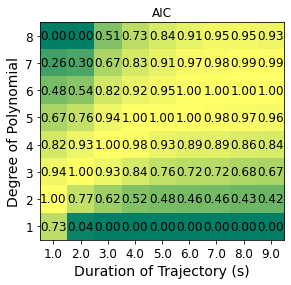

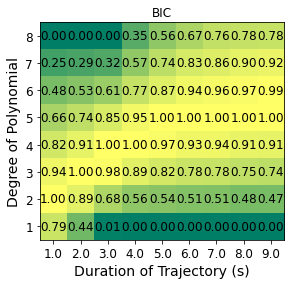

In [10]:
# Visualise AIC, BIC
num_of_points_list = [11, 21, 31, 41, 51, 61, 71, 81, 91]
degrees = [1, 2, 3, 4, 5, 6, 7, 8]
AIC_matrix = np.zeros((8, len(num_of_points_list)))
BIC_matrix = np.zeros((8, len(num_of_points_list)))
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
cmap = mpl.cm.summer
for idx, num_of_points in enumerate(num_of_points_list):
    folder_dir = 'logs/gradient_tape/ego_xy' + str(num_of_points)
    file_name = 'result_summary'
    with open(folder_dir + '/' + file_name + '.json', "r") as read_file:
        result = json.load(read_file)
    AIC_score = np.array(result['aic_scores'])

    AIC_score = -AIC_score # reverse the score, so that the higher the better
    AIC_score_norm = (AIC_score - np.amin(AIC_score))/(np.amax(AIC_score) - np.amin(AIC_score))
    AIC_matrix[:, idx] = AIC_score_norm[::-1]
    
    BIC_score = np.array(result['bic_scores'])

    BIC_score = -BIC_score # reverse the score, so that the higher the better
    BIC_score_norm = (BIC_score - np.amin(BIC_score))/(np.amax(BIC_score) - np.amin(BIC_score))
    BIC_matrix[:, idx] = BIC_score_norm[::-1]


ax.imshow(AIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(AIC_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax.set_xticks(np.arange(0, AIC_matrix.shape[1], 1));
ax.set_yticks(np.arange(0, AIC_matrix.shape[0], 1));
ax.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax.set_yticklabels(degrees[::-1]);


ax2.imshow(BIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(BIC_matrix):
    ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax2.set_xticks(np.arange(0, BIC_matrix.shape[1], 1));
ax2.set_yticks(np.arange(0, BIC_matrix.shape[0], 1));
ax2.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax2.set_yticklabels(degrees[::-1]);

#ax.set_title('Normalized avg. AIC (higher value is better)')
ax.set_title('AIC')
ax.set_ylabel('Degree of Polynomial')
ax.set_xlabel('Duration of Trajectory (s)')

fig.show()
fig.savefig('imgs/Waymo Normalized AIC related to the Duration of Trajectory.jpg', dpi = 600)

#ax2.set_title('Normalized avg. BIC (higher value is better)')
ax2.set_title('BIC')
ax2.set_ylabel('Degree of Polynomial')
ax2.set_xlabel('Duration of Trajectory (s)')

fig2.show()
fig2.savefig('imgs/Waymo Normalized BIC related to the Duration of Trajectory.jpg', dpi = 600)

# Evaluation 2: Analyse Fitting Error

## Load Data

In [11]:
class DataProcessor(object):
    def __init__(self, batch_size, dataset, num_points_in_one_traj):
        self.batch_size = batch_size
        self.dataset = dataset  
        self.num_points_in_one_traj = num_points_in_one_traj
        self.loaded_dataset = None
    
    def _extract_ego_trajs(self, file_path, start_idx):
        file_str = str(file_path.numpy())[2:-1]
        ego_trajs_all = []
        times_all = []
        with open(file_str, "r") as read_file:
            traj_data = json.load(read_file)
            
        ego_traj_temp = np.array(traj_data['ego_traj'])[start_idx : start_idx+self.num_points_in_one_traj, [0,1,3]] #x, y, z heading, vx, vy
        ego_traj_temp[:, :2] = ego_traj_temp[:, :2] - ego_traj_temp[0,:2] # let trajectories start from zero
        ego_traj = np.concatenate((ego_traj_temp[:, 0], ego_traj_temp[:, 1]), axis = 0)
        
        heading_vector = np.array([np.cos(ego_traj_temp[:, 2]), np.sin(ego_traj_temp[:, 2])]).T

        times = np.array(traj_data['timestamp'])[start_idx: start_idx+self.num_points_in_one_traj]
        times = times - times[0]
        
        return tf.convert_to_tensor(times, dtype=tf.float32), tf.convert_to_tensor(ego_traj, dtype=tf.float32), heading_vector
    
    
    def _load_data(self, file_path, start_idx):
        return tf.py_function(self._extract_ego_trajs, [file_path, start_idx], [tf.float32, tf.float32, tf.float32])
    
    def load_process(self, shuffle = False):
        self.loaded_dataset = self.dataset.map(map_func = self._load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        self.loaded_dataset = self.loaded_dataset.cache()

        # Shuffle data and create batches
        if shuffle:
            self.loaded_dataset = self.loaded_dataset.shuffle(buffer_size=self.loaded_dataset.__len__())
        
        # Set batch size for dataset
        self.loaded_dataset = self.loaded_dataset.batch(self.batch_size)

        # Make dataset fetch batches in the background during the training of the model.
        self.loaded_dataset = self.loaded_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
    def get_batch(self):
        return next(iter(self.loaded_dataset))

In [49]:
BATCH_SIZE = 1024

original_num_points_in_one_traj = 91
num_points_in_one_traj = 11

In [50]:
# Load results
prior_folder_dir = 'logs/gradient_tape/ego_xy' + str(num_points_in_one_traj)
file_name = 'result_summary'

# Load prior parameters
with open(prior_folder_dir + '/' + file_name + '.json', "r") as read_file:
    result = json.load(read_file)

with open("data/ego_trajs_not_moving_indicies.json", "r") as read_file:
    idx_not_moving = set(json.load(read_file))
    
with open("data/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_outlier_indicies.json", "r") as read_file:
    idx_outlier = set(json.load(read_file))

idx_invalid = idx_outlier | idx_not_moving
    

list_dataset = generate_file_list_dataset('data/ego_trajs_json/', idx_invalid)
start_idx_dataset = generate_start_indicies_dataset("data/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_start_point_indicies.json", idx_invalid)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj)
dataProcessor.load_process()

print(dataProcessor.loaded_dataset.__len__())     

100%|██████████| 487002/487002 [00:00<00:00, 1937193.02it/s]


tf.Tensor(377, shape=(), dtype=int64)


In [51]:
with open("data/ego_trajs_" + str(num_points_in_one_traj) + "_json/ego_trajs_filtered_CA.json", "r") as read_file:
    ego_smoothed_traj = np.array(json.load(read_file))[:, :, [0,3]] 

In [52]:
smoothed_traj_dataset = tf.data.Dataset.from_tensor_slices(preprocess_smoothed_ego_trajs(ego_smoothed_traj, idx_invalid))
smoothed_traj_dataset = smoothed_traj_dataset.batch(BATCH_SIZE)
print(smoothed_traj_dataset.__len__())  

tf.Tensor(377, shape=(), dtype=int64)


In [53]:
degrees = result['degree']


errors_gt_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(),  num_points_in_one_traj))
errors_gt_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_kf_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))
errors_kf_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_gt_kf_lon = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))
errors_gt_kf_lat = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))

for idx_deg, deg in enumerate(tqdm(degrees)):
    current_batch_idx = 0
    print('Processing deg: ', deg)
    
    for (t_samples, mess_traj_samples, heading_samples), ks_traj_samples in zip(dataProcessor.loaded_dataset, smoothed_traj_dataset):
        next_batch_idx = current_batch_idx + mess_traj_samples.shape[0]
        t_samples = t_samples.numpy()
        mess_traj_samples = mess_traj_samples.numpy()
        heading_samples = heading_samples.numpy()
        ks_traj_samples = ks_traj_samples.numpy()
        
        ks_traj_samples =  np.concatenate((ks_traj_samples[:, :, 0], ks_traj_samples[:, :, 1]), axis = 1)
        

        heading_norm_samples = heading_samples[:, :, [1,0]] 
        heading_norm_samples[:, :, 0] = -heading_norm_samples[:, :, 0]
        
        
        phi_t_batch = expand(t_samples, bf=polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
        phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])

        A = np.array(result['A_list'][idx_deg])
        B_by_diag = np.eye(num_points_in_one_traj) * result['B_list'][idx_deg]['B_by_diag']
        by_eye = np.array([[0,1],[1,0]])
        B_diag = np.eye(2*num_points_in_one_traj) * result['B_list'][idx_deg]['B_diag']
        B = B_diag  + np.kron(by_eye, B_by_diag)
        
        S_N = np.linalg.inv(np.linalg.inv(A) + np.transpose(phi_t_kron, (0,2,1)) @ np.linalg.inv(B) @ phi_t_kron)
    
        mu_N = S_N @ np.transpose(phi_t_kron, (0,2,1)) @ np.linalg.inv(B) @ mess_traj_samples[:, :, None]
    
        pred = (phi_t_kron @ mu_N )[:, :, 0]
        
        
        error_gt_poly_x = mess_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_gt_poly_y = mess_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_gt_poly_lon, error_gt_poly_lat, _ = project_error(error_gt_poly_x, error_gt_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lon
        errors_gt_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lat

        error_kf_poly_x = ks_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_kf_poly_y = ks_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_kf_poly_lon, error_kf_poly_lat, _ = project_error(error_kf_poly_x, error_kf_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_kf_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lon
        errors_kf_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lat
        
        
        error_x_gt_kf = mess_traj_samples[:, :num_points_in_one_traj] - ks_traj_samples[:, :num_points_in_one_traj]
        error_y_gt_kf = mess_traj_samples[:, num_points_in_one_traj:] - ks_traj_samples[:, num_points_in_one_traj:]
        error_gt_kf_lon, error_gt_kf_lat, _ = project_error(error_x_gt_kf, error_y_gt_kf, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_kf_lon[current_batch_idx: next_batch_idx] = error_gt_kf_lon
        errors_gt_kf_lat[current_batch_idx: next_batch_idx] = error_gt_kf_lat
        
        current_batch_idx = next_batch_idx

print('finished')      

  0%|          | 0/8 [00:00<?, ?it/s]

Processing deg:  1


 12%|█▎        | 1/8 [16:06<1:52:42, 966.06s/it]

Processing deg:  2


 25%|██▌       | 2/8 [16:27<41:01, 410.18s/it]  

Processing deg:  3


 38%|███▊      | 3/8 [17:08<20:09, 241.90s/it]

Processing deg:  4


 50%|█████     | 4/8 [17:50<10:51, 162.77s/it]

Processing deg:  5


 62%|██████▎   | 5/8 [18:31<05:57, 119.06s/it]

Processing deg:  6


 75%|███████▌  | 6/8 [19:13<03:05, 92.76s/it] 

Processing deg:  7


 88%|████████▊ | 7/8 [19:54<01:15, 75.99s/it]

Processing deg:  8


100%|██████████| 8/8 [21:17<00:00, 159.69s/it]

finished


In [54]:
summary_lon = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in longitudinal')
print('Mess vs Poly')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['gt_poly'] = summary_temp
    
    
summary_temp = []
print('\n')
print('KF vs Poly')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('KF vs Mess')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), [99.9]), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)))
summary_lon['gt_kf'] = [np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), 99.9), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)]

Error in longitudinal
Mess vs Poly
Deg: 1, Mean: 0.03574, Median: 0.02048, 99.9% Percentil: 0.24673, Max: 1.24374; Min: 0.00000
Deg: 2, Mean: 0.00238, Median: 0.00101, 99.9% Percentil: 0.05620, Max: 1.14718; Min: 0.00000
Deg: 3, Mean: 0.00113, Median: 0.00042, 99.9% Percentil: 0.04668, Max: 0.79636; Min: 0.00000
Deg: 4, Mean: 0.00084, Median: 0.00030, 99.9% Percentil: 0.04194, Max: 0.76071; Min: 0.00000
Deg: 5, Mean: 0.00084, Median: 0.00030, 99.9% Percentil: 0.04193, Max: 0.73145; Min: 0.00000
Deg: 6, Mean: 0.00076, Median: 0.00028, 99.9% Percentil: 0.03991, Max: 0.69675; Min: 0.00000
Deg: 7, Mean: 0.00070, Median: 0.00026, 99.9% Percentil: 0.03855, Max: 0.67168; Min: 0.00000
Deg: 8, Mean: 0.00070, Median: 0.00026, 99.9% Percentil: 0.03818, Max: 0.66860; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.03526, Median: 0.02005, 99.9% Percentil: 0.24464, Max: 1.13059; Min: 0.00000
Deg: 2, Mean: 0.00112, Median: 0.00046, 99.9% Percentil: 0.02505, Max: 1.01481; Min: 0.00000
Deg: 3, Mean: 0.00190,

In [55]:
summary_lat = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in lateral')
print('Mess vs Poly')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['gt_poly'] = summary_temp

summary_temp = []
print('\n')
print('KF vs Poly')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('KF vs Mess')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), [99.9]), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)))
summary_lat['gt_kf'] = [np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), 99.9), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)]

Error in lateral
Mess vs Poly
Deg: 1, Mean: 0.01078, Median: 0.00104, 99.9% Percentil: 0.26644, Max: 0.54542; Min: 0.00000
Deg: 2, Mean: 0.00085, Median: 0.00036, 99.9% Percentil: 0.01299, Max: 0.07705; Min: 0.00000
Deg: 3, Mean: 0.00042, Median: 0.00025, 99.9% Percentil: 0.00501, Max: 0.05492; Min: 0.00000
Deg: 4, Mean: 0.00036, Median: 0.00021, 99.9% Percentil: 0.00423, Max: 0.04183; Min: 0.00000
Deg: 5, Mean: 0.00036, Median: 0.00022, 99.9% Percentil: 0.00425, Max: 0.04628; Min: 0.00000
Deg: 6, Mean: 0.00035, Median: 0.00021, 99.9% Percentil: 0.00411, Max: 0.04346; Min: 0.00000
Deg: 7, Mean: 0.00034, Median: 0.00020, 99.9% Percentil: 0.00396, Max: 0.04003; Min: 0.00000
Deg: 8, Mean: 0.00034, Median: 0.00020, 99.9% Percentil: 0.00391, Max: 0.04113; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.01065, Median: 0.00091, 99.9% Percentil: 0.26450, Max: 0.54041; Min: 0.00000
Deg: 2, Mean: 0.00038, Median: 0.00014, 99.9% Percentil: 0.01007, Max: 0.05853; Min: 0.00000
Deg: 3, Mean: 0.00064, Medi

In [56]:
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/gt_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lon, write_file, cls=NumpyEncoder)
    
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/gt_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lat, write_file, cls=NumpyEncoder)
    
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/kf_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lon, write_file, cls=NumpyEncoder)
    
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/kf_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lat, write_file, cls=NumpyEncoder)
    
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/gt_kf_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lon, write_file, cls=NumpyEncoder)
    
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/gt_kf_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lat, write_file, cls=NumpyEncoder)

In [57]:
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/summary_lon' + '.json', "w") as write_file:
    json.dump(summary_lon, write_file, cls=NumpyEncoder)
    
with open('results/ego_pos_error/' + str(num_points_in_one_traj) + '/summary_lat' + '.json', "w") as write_file:
    json.dump(summary_lat, write_file, cls=NumpyEncoder)